<a id='home'></a>
### purpose

create figs that show predicted offset to future climates - choose which model to use based on model validation performance - WZA was generally the best or on par with best locus set

### outline

1. [get population data](#popdata)
1. [get offset data](#offset)
1. [create slope graphs to compare cross-variety model ranks to variety-specific model ranks](#slope)
1. [create offset maps to future climates](#maps)
1. [create offset maps to common gardens](#garden)
1. [create README for directory](#readme)

In [1]:
from pythonimports import *
from myfigs import save_pdf, slope_graph, create_cmap, gradient_image

import xarray
import rioxarray

# files created in ../07_fit_gradient_forest_models_to_climate_data.ipynb
netcdf_dir = '/data/projects/pool_seq/phenotypic_data/offset_misc_files/fitting'

# where to save
figdir = makedir('/data/projects/pool_seq/phenotypic_data/offset_misc_files/projection_figs')
gfdir = '/data/projects/pool_seq/phenotypic_data/offset_misc_files/results/gradient_forests'

# notebook timer
t1 = dt.now()

# env info
latest_commit()
session_info.show()

##################################################################
Current commit of pythonimports:
commit 51393d65f6b4f97bf9245fc37ae3c0a6cb41ca6b  
Author: Brandon Lind <lind.brandon.m@gmail.com>  
Date:   Mon Sep 12 14:32:41 2022 -0400
Today:	October 27, 2022 - 09:41:49
python version: 3.8.5
##################################################################



<a id='popdata'></a>
# 1. get population data

[top](#home)

In [2]:
envdata = {}
pop_colors = {}

##### jack pine

In [3]:
# population data
jppopdata = pd.read_table('/data/projects/pool_seq/environemental_data/jp_rm_p24/jp_no-p24_raw_env-19variables.txt')
jppopdata.index = jppopdata['our_id'].tolist()

envdata['jp'] = jppopdata

pop_colors['jp'] = dict(zip(jppopdata.index, jppopdata['group_color']))

jppopdata.head()

id1  id2   our_id      LAT      LONG  Elevation   AHM  CMD   DD5  \
JP_p98   9150251   38   JP_p98  54.3333 -106.6333        537  21.2  181  1273   
JP_p73      3273   22   JP_p73  44.4200  -84.6800        359  22.0  241  1956   
JP_p97   8060006   37   JP_p97  56.1167 -116.9167        636  23.5  242  1188   
JP_p60      3260   17   JP_p60  46.7200  -84.3900        203  16.5  135  1557   
JP_p100  9040116   40  JP_p100  55.7667  -97.8167        205  13.3  130  1003   

         DD_0   EMT   EXT  Eref  FFP  MAP  MAT  MCMT  MSP  MWMT  NFFD  PAS  \
JP_p98   2217 -46.0  34.7   534  103  461 -0.2 -20.1  305  16.6   149  129   
JP_p73    835 -34.1  36.6   745  131  732  6.1  -8.0  395  19.8   163  140   
JP_p97   2009 -44.3  34.8   556   90  432  0.2 -19.8  272  15.4   138  133   
JP_p60   1116 -36.8  34.3   599  123  848  4.0 -10.7  397  17.6   156  265   
JP_p100  2956 -49.7  35.2   448   82  506 -3.3 -24.9  315  15.7   106  191   

          SHM    TD  bFFP  eFFP group_color  
JP_p98   54.4  36.7   148   251       green  
JP_p73   50.0  27.8   141   271        blue  
JP_p97   56.5  35.1   151   241       green  
JP_p60   44.2  28.3   147   271        blue  
JP_p100  49.9  40.6   163   245       green

##### doug-fir

In [4]:
# genetic group colors
dfdf = pd.read_table('/data/projects/pool_seq/environemental_data/change_p6/doug-fir_colored_pops.txt')
dfdf.loc[dfdf['our_id']=='DF_p40', ['group', 'group_color']] = 'North BC', '#f205f4'
pop_colors['combined'] = dict(zip(dfdf['our_id'], dfdf['group_color']))

In [5]:
# population data
dfdata = pd.read_table('/data/projects/pool_seq/environemental_data/change_p6/df_ALL-naturalpops_raw_env-19variables_change-p6.txt')
dfdata['color'] = dfdata['our_id'].map(pop_colors['combined'])
dfdata.index = dfdata['our_id'].tolist()

envdata['combined'] = dfdata

envdata['fdc'] = dfdata[dfdata['Variety']=='FDC'].copy()
pop_colors['fdc'] = dict(zip(envdata['fdc'].index, envdata['fdc']['color']))

envdata['fdi'] = dfdata[dfdata['Variety']=='FDI'].copy()
pop_colors['fdi'] = dict(zip(envdata['fdi'].index, envdata['fdi']['color']))

assert nrow(envdata['fdc']) + nrow(envdata['fdi']) == nrow(envdata['combined'])

dfdata.head()

prov our_id Variety    LONG    LAT  Elevation  MAT  MWMT  MCMT    TD  \
DF_p1     1  DF_p1     FDC -126.63  49.78        225  8.4  15.6   2.3  13.3   
DF_p2     2  DF_p2     FDC -122.73  50.32        550  6.1  16.4  -4.4  20.8   
DF_p3     3  DF_p3     FDI -115.62  50.54       1525  1.6  13.4 -10.7  24.1   
DF_p4     4  DF_p4     FDI -122.33  52.04        900  3.9  15.3  -9.2  24.5   
DF_p5     5  DF_p5     FDI -119.05  49.02        853  6.0  17.7  -6.2  23.9   

        MAP  MSP   AHM    SHM  DD_0   DD5  NFFD  bFFP  eFFP  FFP  PAS   EMT  \
DF_p1  4004  778   4.6   20.0   143  1644   277   115   301  186  242 -18.3   
DF_p2  1029  225  15.6   73.0   518  1521   202   135   272  137  330 -30.9   
DF_p3   630  321  18.5   41.8  1242   929   130   171   244   73  261 -43.3   
DF_p4   423  196  32.9   78.2   919  1270   158   154   255  101  149 -40.2   
DF_p5   367  171  43.8  103.6   637  1650   182   142   265  123  100 -34.8   

        EXT  Eref  CMD    color  
DF_p1  33.3   606   10  #a6cee3  
DF_p2  35.2   659  307  #33a02c  
DF_p3  32.6   548  151  #22ff00  
DF_p4  34.9   598  350  #f205f4  
DF_p5  37.7   732  497  #995bbe

<a id='offset'></a>
# 2. get offset data
[top](#home)

In [6]:
# get offset projected to future climates for each model using WZA loci and all populations
netcdf_dir = '/data/projects/pool_seq/phenotypic_data/offset_misc_files/fitting'
ncfiles = fs(netcdf_dir,
             pattern='-wza-real-full',
             exclude=['wl-', 'NA_NORM', 'vancouver', 'christine', 'fontbrune'],
             endswith='.nc')

[op.basename(f) for f in ncfiles]

['combined-wza-real-full_gradient_forest_training_NA_ENSEMBLE_rcp45_2050s_all-envs_WGS84_clipped_combined_offset.nc',
 'combined-wza-real-full_gradient_forest_training_NA_ENSEMBLE_rcp45_2080s_all-envs_WGS84_clipped_combined_offset.nc',
 'combined-wza-real-full_gradient_forest_training_NA_ENSEMBLE_rcp85_2050s_all-envs_WGS84_clipped_combined_offset.nc',
 'combined-wza-real-full_gradient_forest_training_NA_ENSEMBLE_rcp85_2080s_all-envs_WGS84_clipped_combined_offset.nc',
 'fdc-wza-real-full_gradient_forest_training_NA_ENSEMBLE_rcp45_2050s_all-envs_WGS84_clipped_coastal_offset.nc',
 'fdc-wza-real-full_gradient_forest_training_NA_ENSEMBLE_rcp45_2080s_all-envs_WGS84_clipped_coastal_offset.nc',
 'fdc-wza-real-full_gradient_forest_training_NA_ENSEMBLE_rcp85_2050s_all-envs_WGS84_clipped_coastal_offset.nc',
 'fdc-wza-real-full_gradient_forest_training_NA_ENSEMBLE_rcp85_2080s_all-envs_WGS84_clipped_coastal_offset.nc',
 'fdi-wza-real-full_gradient_forest_training_NA_ENSEMBLE_rcp45_2050s_all-envs_WG

<a id='slope'></a>
# 3. create slope graphs to compare cross-variety model ranks to variety-specific model ranks

[top](#home)

In [7]:
# functions from ../11_validate_GF_offset_predictions.ipynb

def read_offset_file(offset_file, x_dim="latitude", y_dim="longitude"):
    """Read in netcdf file."""
    import xarray as xr
    import rioxarray

    ds = xr.open_dataset(offset_file)
    ds.rio.set_spatial_dims(x_dim=x_dim, y_dim=y_dim, inplace=True)
    ds.rio.write_crs("epsg:4326", inplace=True)
    
    layers = [var for var in list(ds.variables) if var not in ['crs', 'longitude', 'latitude']]
    assert len(layers) == 1
    layer = layers[0]
    vals = ds[layer][:,:]
    lons = ds[layer]['longitude']
    lats = ds[layer]['latitude']
    
    return ds, layer, vals, lons, lats


def get_offset_data(offset_file, envdata, latcol='LAT', loncol='LONG'):
    """Read in offset data from netCDF `offset_file` for each of the pops in `envdata`."""
    import xarray as xr

    # read in offset data
    ds,layer,*args = read_offset_file(offset_file)

    # pull offset values directly from the shapefile
    target_lat = xr.DataArray(envdata[latcol], dims='points')
    target_lon = xr.DataArray(envdata[loncol], dims='points')
    offsets = ds[layer].sel(longitude=target_lon, latitude=target_lat, method='nearest').to_dataframe()
    offsets.index = envdata['our_id'].tolist()
    
    try:
        assert offsets[offsets.columns[-1]].isnull().sum() == 0
    except AssertionError as e:
        # there can be null vals if a population resides outside of the shapefile boundaries ...
        # ... when shapefiles have been used to clip climate data
        print(offset_file, envdata.index)
        raise e

    return offsets


In [8]:
# read offset data from GIS files
offsets = defaultdict(dict)
for nc in pbar(ncfiles):
    spp = op.basename(nc).split("-")[0]
    ensemble = op.basename(nc).split("ENSEMBLE_")[1].split("_all-envs")[0]
    
    offsets[spp][ensemble] = get_offset_data(nc, envdata[spp])

100%|███████████████| 16/16 [00:02<00:00,  7.10it/s]


In [9]:
# save offsets
pkl = op.join(gfdir, 'gf_offsets_to_future.pkl')
pkldump(offsets, pkl)

pkl

'/data/projects/pool_seq/phenotypic_data/offset_misc_files/results/gradient_forests/gf_offsets_to_future.pkl'

In [10]:
keys(envdata)

['jp', 'combined', 'fdc', 'fdi']

Saved to:  /data/projects/pool_seq/phenotypic_data/offset_misc_files/projection_figs/northwestern_rcp45_2050s_scatter_slope.pdf


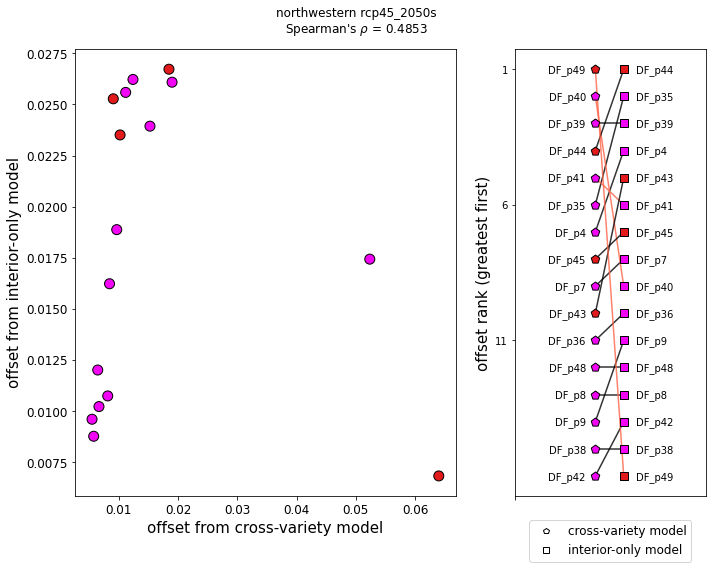

Saved to:  /data/projects/pool_seq/phenotypic_data/offset_misc_files/projection_figs/southeastern_rcp45_2050s_scatter_slope.pdf


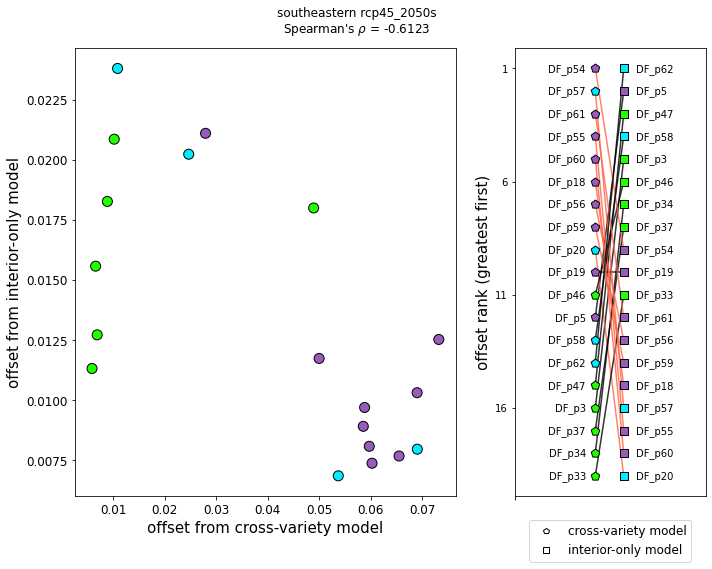

Saved to:  /data/projects/pool_seq/phenotypic_data/offset_misc_files/projection_figs/interior_rcp45_2050s_scatter_slope.pdf


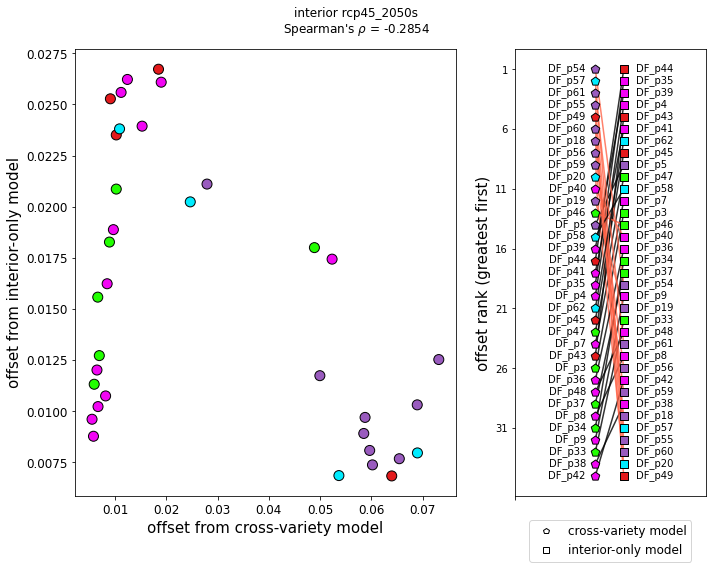

Saved to:  /data/projects/pool_seq/phenotypic_data/offset_misc_files/projection_figs/coastal_rcp45_2050s_scatter_slope.pdf


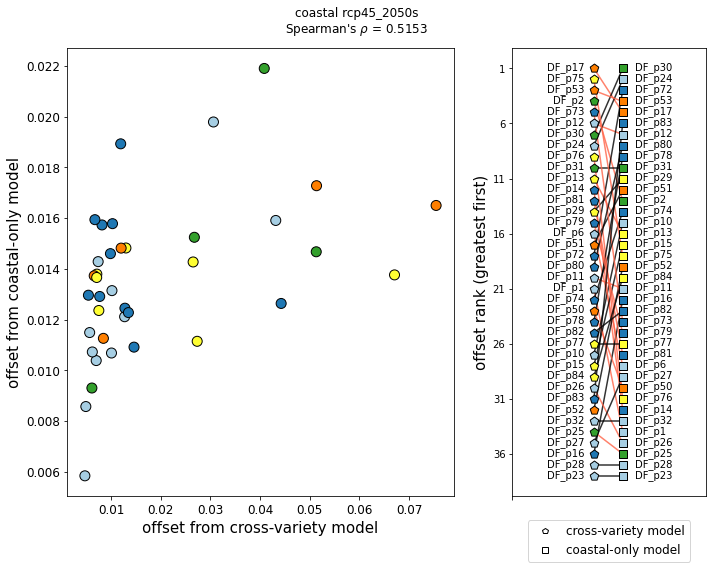

Saved to:  /data/projects/pool_seq/phenotypic_data/offset_misc_files/projection_figs/northwestern_rcp45_2080s_scatter_slope.pdf


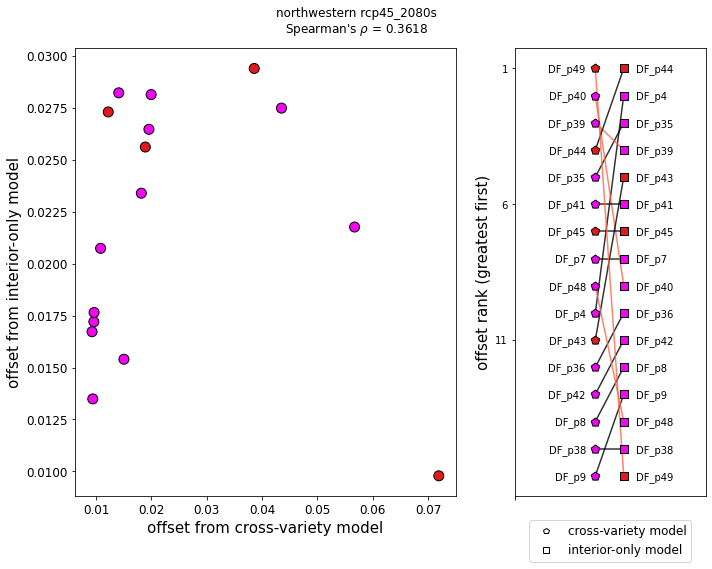

Saved to:  /data/projects/pool_seq/phenotypic_data/offset_misc_files/projection_figs/southeastern_rcp45_2080s_scatter_slope.pdf


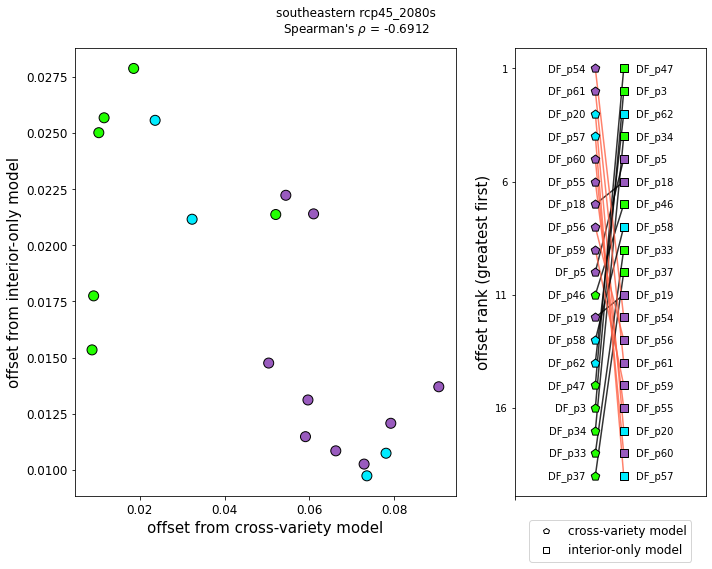

Saved to:  /data/projects/pool_seq/phenotypic_data/offset_misc_files/projection_figs/interior_rcp45_2080s_scatter_slope.pdf


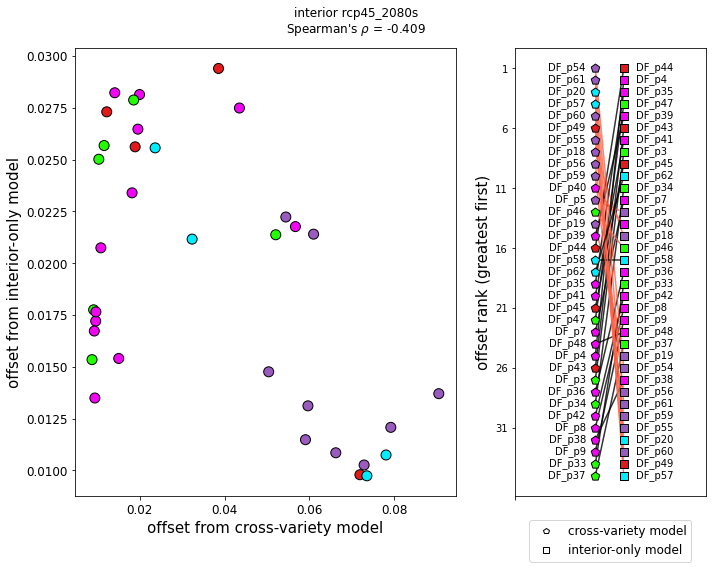

Saved to:  /data/projects/pool_seq/phenotypic_data/offset_misc_files/projection_figs/coastal_rcp45_2080s_scatter_slope.pdf


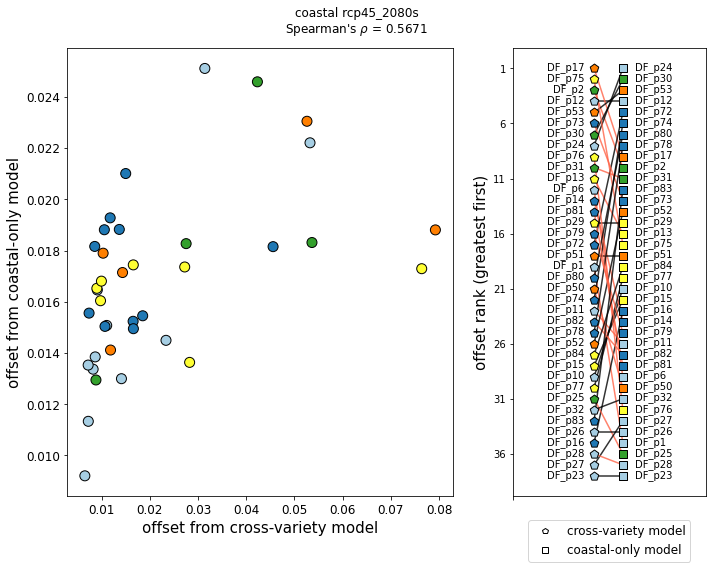

Saved to:  /data/projects/pool_seq/phenotypic_data/offset_misc_files/projection_figs/northwestern_rcp85_2050s_scatter_slope.pdf


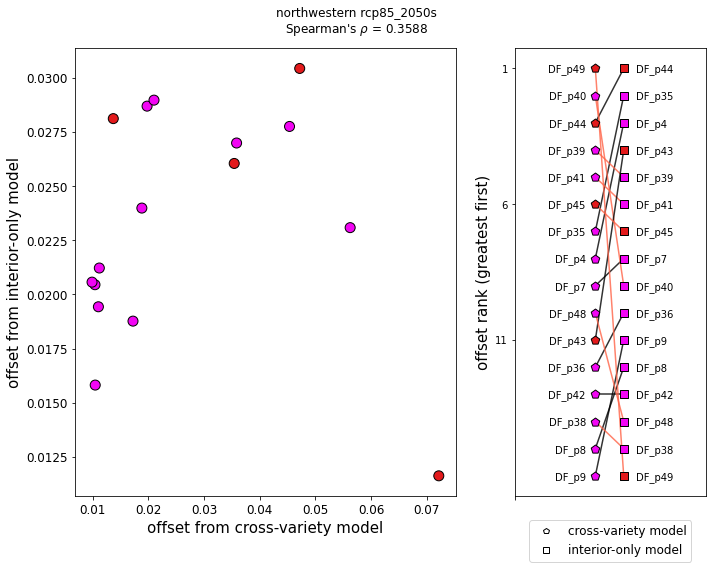

Saved to:  /data/projects/pool_seq/phenotypic_data/offset_misc_files/projection_figs/southeastern_rcp85_2050s_scatter_slope.pdf


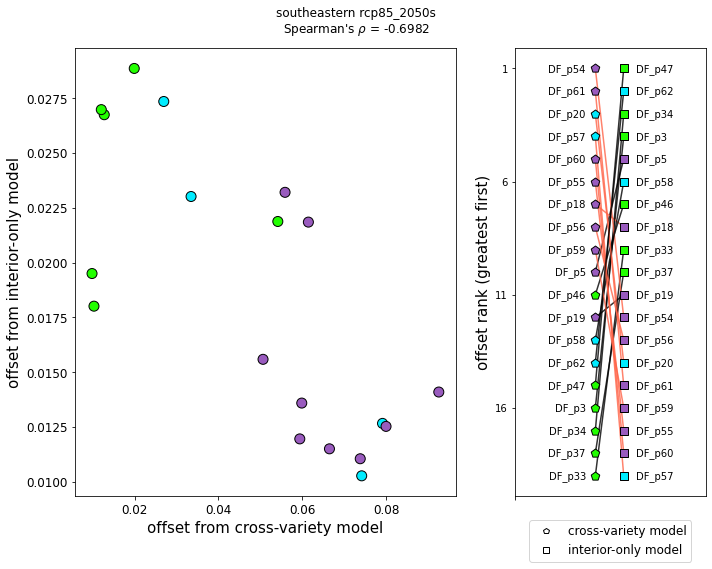

Saved to:  /data/projects/pool_seq/phenotypic_data/offset_misc_files/projection_figs/interior_rcp85_2050s_scatter_slope.pdf


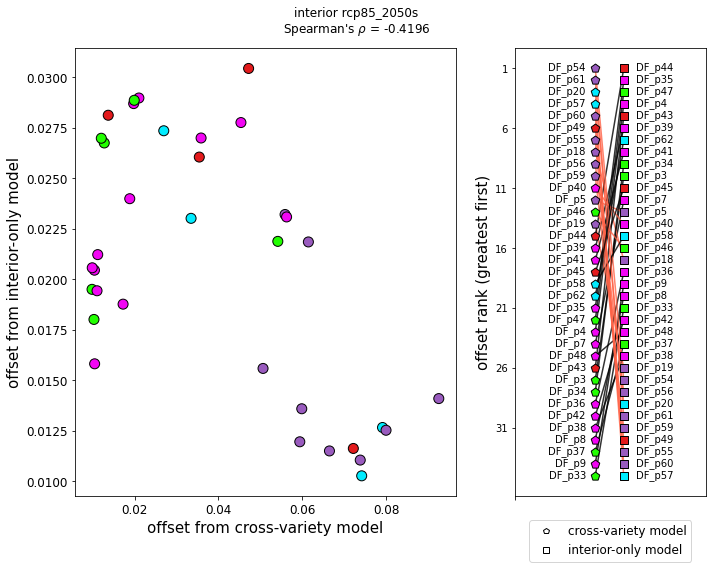

Saved to:  /data/projects/pool_seq/phenotypic_data/offset_misc_files/projection_figs/coastal_rcp85_2050s_scatter_slope.pdf


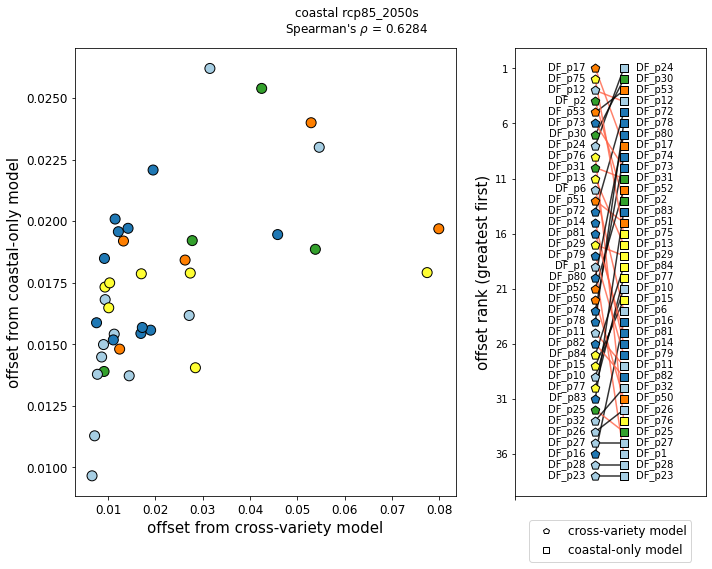

Saved to:  /data/projects/pool_seq/phenotypic_data/offset_misc_files/projection_figs/northwestern_rcp85_2080s_scatter_slope.pdf


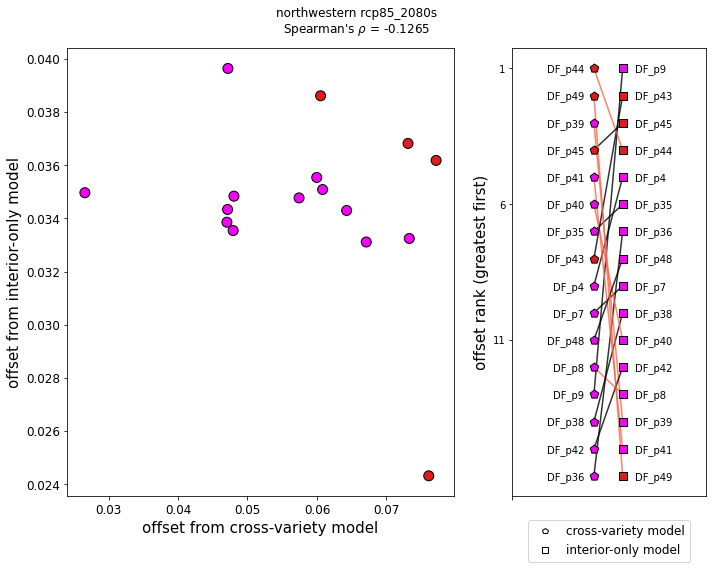

Saved to:  /data/projects/pool_seq/phenotypic_data/offset_misc_files/projection_figs/southeastern_rcp85_2080s_scatter_slope.pdf


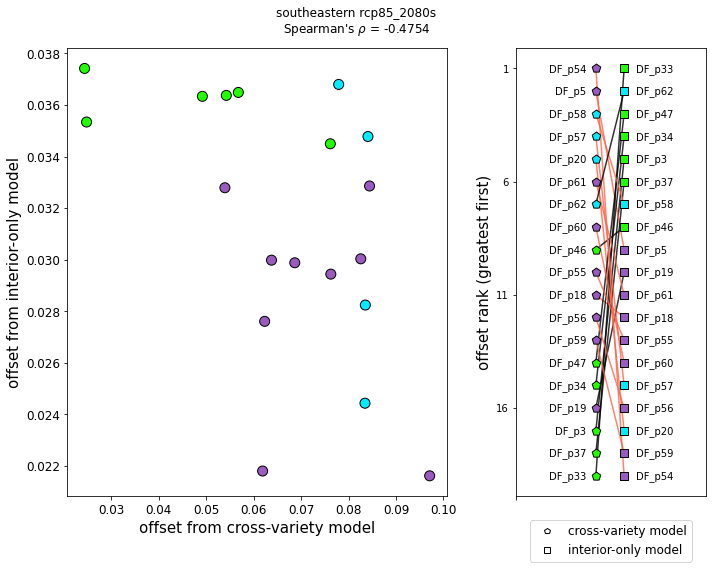

Saved to:  /data/projects/pool_seq/phenotypic_data/offset_misc_files/projection_figs/interior_rcp85_2080s_scatter_slope.pdf


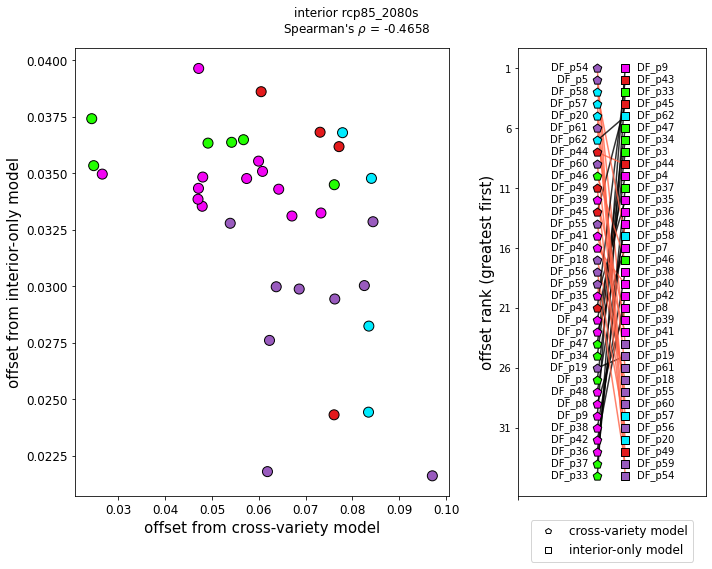

Saved to:  /data/projects/pool_seq/phenotypic_data/offset_misc_files/projection_figs/coastal_rcp85_2080s_scatter_slope.pdf


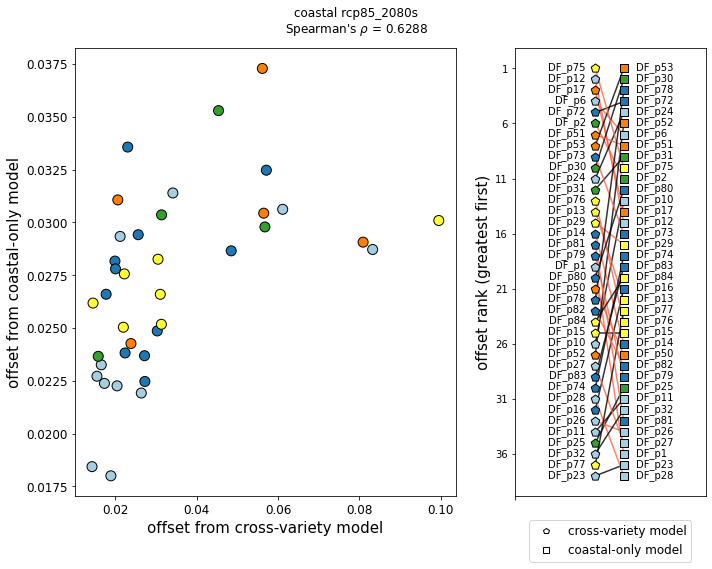

In [11]:
# for each projection, create slope graphs showing rank difference between cross-variety and 
    # interior-only models for each interior genetic group independently
    
# identify pops to use
groups = {'northwestern' : envdata['fdi']['our_id'][envdata['fdi']['color'].isin(['#f205f4', '#e31a1c'])],
          'southeastern' : envdata['fdi']['our_id'][~envdata['fdi']['color'].isin(['#f205f4', '#e31a1c'])],
          'interior' : envdata['fdi']['our_id'],
          'coastal' : envdata['fdc']['our_id']    
}

figsize = (10, 8)
for ensemble in ['rcp45_2050s', 'rcp45_2080s', 'rcp85_2050s', 'rcp85_2080s']:
    for genetic_group, samps in groups.items():
        variety = 'interior' if genetic_group in ['northwestern', 'southeastern', 'interior'] else 'coastal'
        ccolor, offset_key = ('purple', 'fdi') if variety=='interior' else ('lime', 'fdc')
        
        _cmap = create_cmap(['white', ccolor], grain=1000)
        
        # get ranks from combined model
        combined = offsets['combined'][ensemble]
        # subset the combined model to the genetic group in question
        var_combined = combined[combined.columns[-1]].loc[samps]
        
        # get ranks from variety model for the genetic group in question
        var_model = offsets[offset_key][ensemble].loc[samps]
        var_model = var_model[var_model.columns[-1]]
        
        # get colors
        samp_colors = dict((samp,color) for (samp,color) in pop_colors[offset_key].items() if samp in samps)
        
        # create the plots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize, gridspec_kw={'width_ratios': [2, 1]})
        
        ax1.scatter(var_combined, var_model, c=samp_colors.values(), edgecolor='k', s=100)
#         xlim, ylim = ax1.get_xlim(), ax1.get_ylim()
        ax1.set_xlabel('offset from cross-variety model', fontsize=15)
        ax1.set_ylabel(f'offset from {variety}-only model', fontsize=15)
        ax1.tick_params(axis='both', labelsize=12)
#         gradient_image(ax1, direction=0.5, transform=ax1.transAxes, extent=(0,1,0,1),
#                        cmap=_cmap, cmap_range=(0.0, 0.2))  # co-authors didn't like color backgrounds :(

        ax2 = slope_graph(var_combined,
                          var_model,
                          labels=['cross-variety model', f'{variety}-only model'],
                          figsize=(7, 15),
                          ascending=False,
                          ylabel='offset rank (greatest first)',
                          markers=['p', 's'],
                          shape_color=samp_colors,
                          ax=ax2,
                          legendcols=1,
                          bbox_to_anchor=(0.5, -0.1)
                         )
        
        rho = round(var_model.corr(var_combined, method='spearman'), 4)
        plt.suptitle(f"{genetic_group} {ensemble}\nSpearman's " + r"$\rho$" + f" = {rho}")
        plt.tight_layout(w_pad=2)
#         gradient_image(ax2, direction=0.5, transform=ax2.transAxes,
#                        cmap=_cmap, cmap_range=(0.0, 0.2), zorder=0)  # co-authors didn't like color backgrounds :(

        save_pdf(op.join(figdir, f'{genetic_group}_{ensemble}_scatter_slope.pdf'))
        plt.show()
        plt.close()


<a id='maps'></a>
# 4. create offset maps

[top](#home)

##### metadata for function `basemap`

In [12]:
extent = {'jp': [-119.5, -58, 41, 60],
          'combined': [-130, -112.5, 37.5, 55.5],
          'fdc': [-130, -112.5, 37.5, 55.5],
          'fdi': [-130, -112.5, 37.5, 55.5]}

figsize = {'jp': (15, 10),
           'combined': (8, 15),
           'fdc': (8, 15),
           'fdi': (8, 15)}

##### maps

Saved to:  /data/projects/pool_seq/phenotypic_data/offset_misc_files/projection_figs/combined_rcp45_2050s.pdf


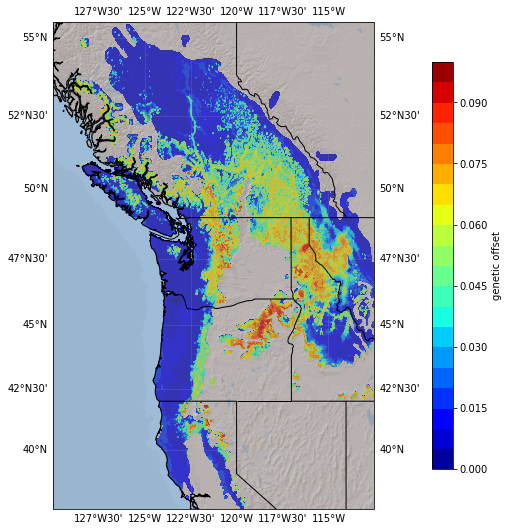

Saved to:  /data/projects/pool_seq/phenotypic_data/offset_misc_files/projection_figs/combined_rcp45_2080s.pdf


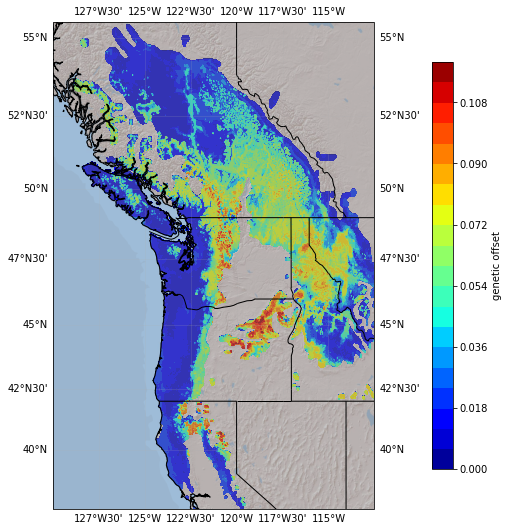

Saved to:  /data/projects/pool_seq/phenotypic_data/offset_misc_files/projection_figs/combined_rcp85_2050s.pdf


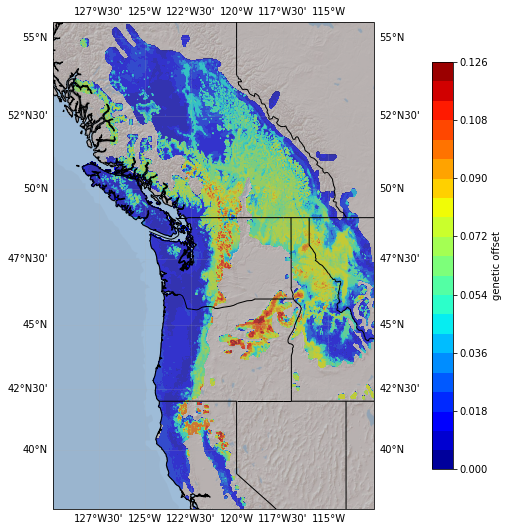

Saved to:  /data/projects/pool_seq/phenotypic_data/offset_misc_files/projection_figs/combined_rcp85_2080s.pdf


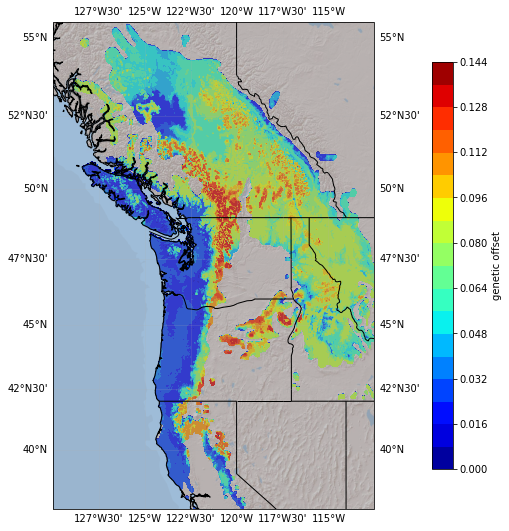

Saved to:  /data/projects/pool_seq/phenotypic_data/offset_misc_files/projection_figs/fdc_rcp45_2050s.pdf


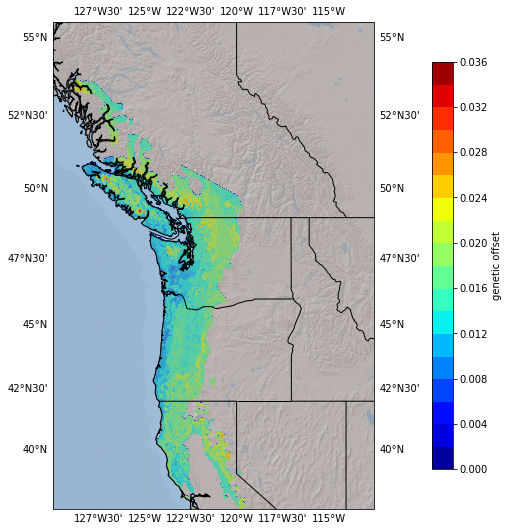

Saved to:  /data/projects/pool_seq/phenotypic_data/offset_misc_files/projection_figs/fdc_rcp45_2080s.pdf


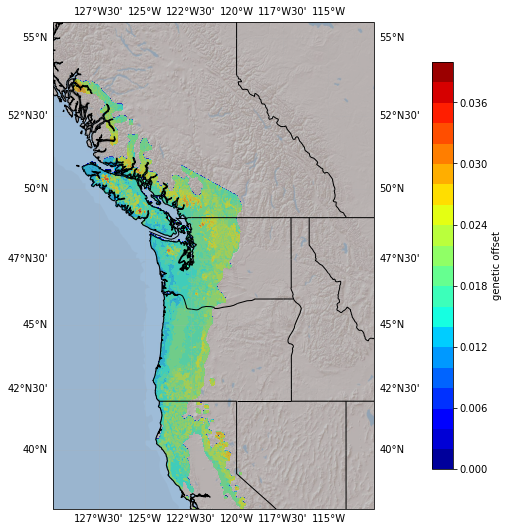

Saved to:  /data/projects/pool_seq/phenotypic_data/offset_misc_files/projection_figs/fdc_rcp85_2050s.pdf


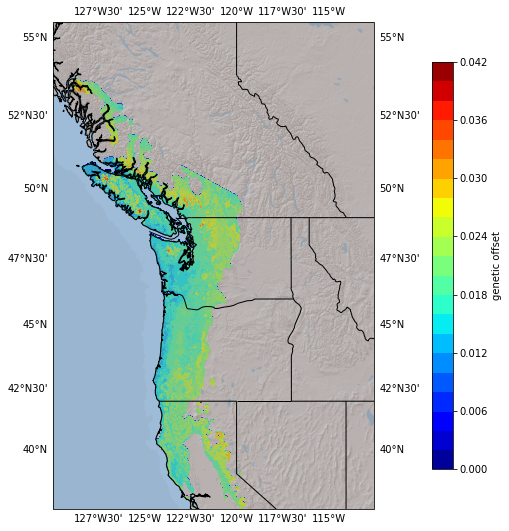

Saved to:  /data/projects/pool_seq/phenotypic_data/offset_misc_files/projection_figs/fdc_rcp85_2080s.pdf


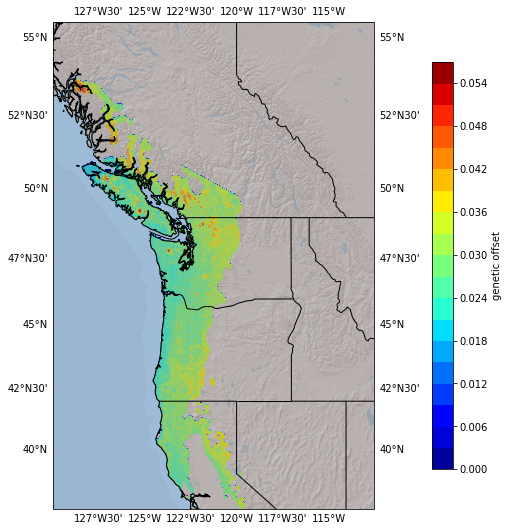

Saved to:  /data/projects/pool_seq/phenotypic_data/offset_misc_files/projection_figs/fdi_rcp45_2050s.pdf


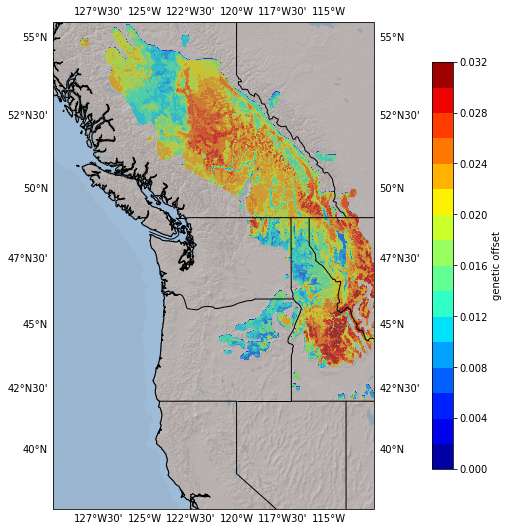

Saved to:  /data/projects/pool_seq/phenotypic_data/offset_misc_files/projection_figs/fdi_rcp45_2080s.pdf


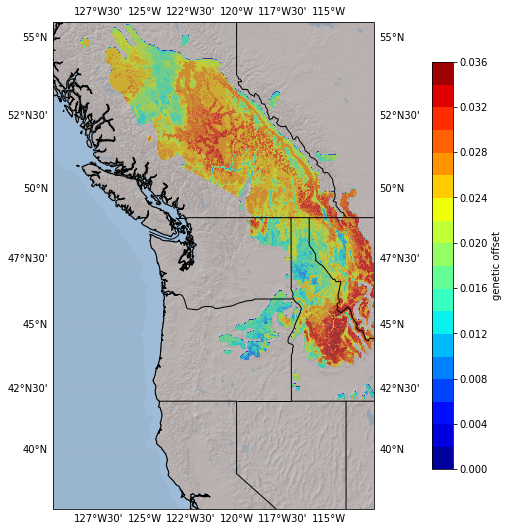

Saved to:  /data/projects/pool_seq/phenotypic_data/offset_misc_files/projection_figs/fdi_rcp85_2050s.pdf


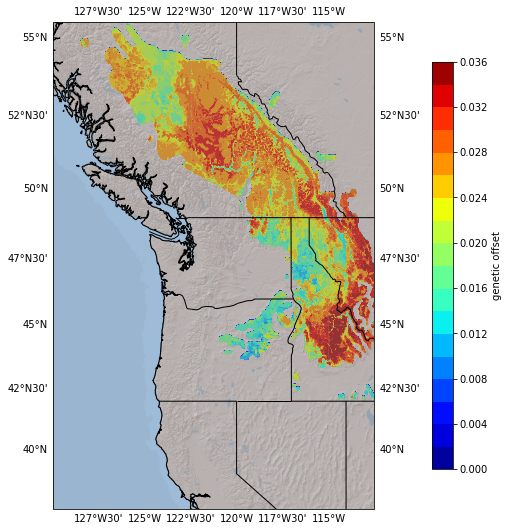

Saved to:  /data/projects/pool_seq/phenotypic_data/offset_misc_files/projection_figs/fdi_rcp85_2080s.pdf


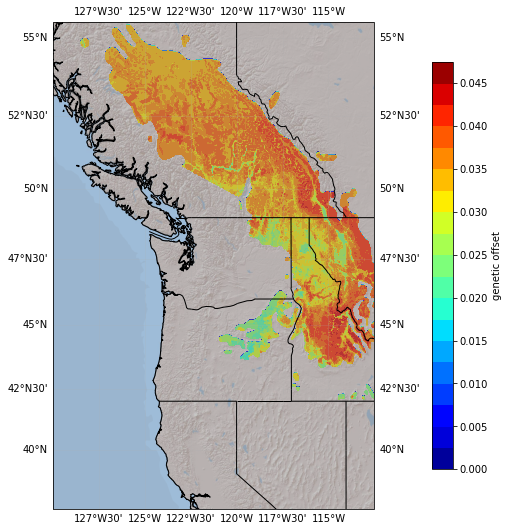

Saved to:  /data/projects/pool_seq/phenotypic_data/offset_misc_files/projection_figs/jp_rcp45_2050s.pdf


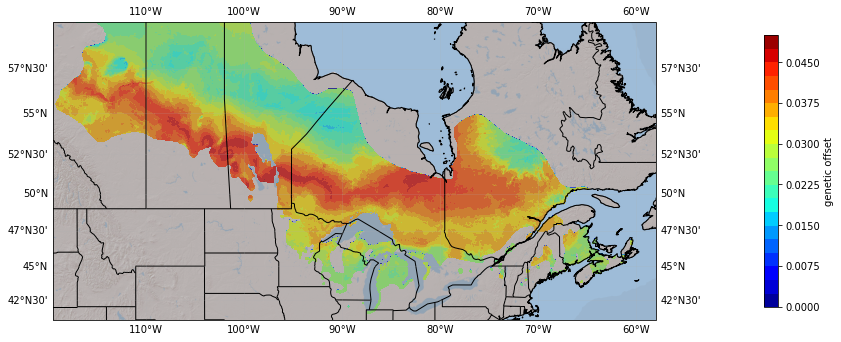

Saved to:  /data/projects/pool_seq/phenotypic_data/offset_misc_files/projection_figs/jp_rcp45_2080s.pdf


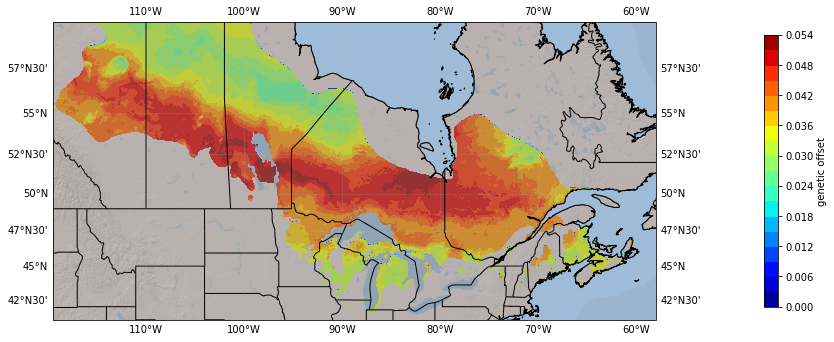

Saved to:  /data/projects/pool_seq/phenotypic_data/offset_misc_files/projection_figs/jp_rcp85_2050s.pdf


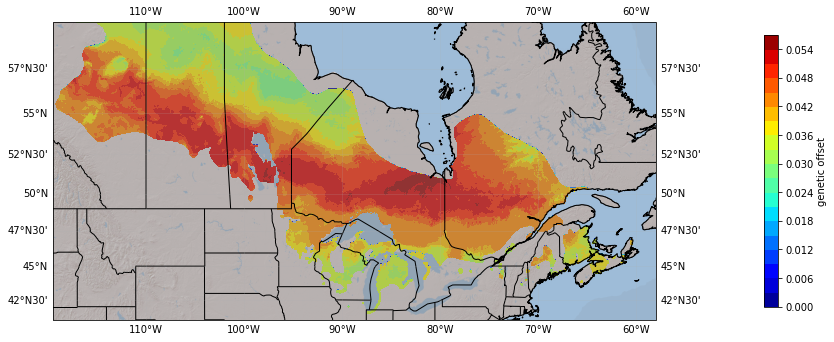

Saved to:  /data/projects/pool_seq/phenotypic_data/offset_misc_files/projection_figs/jp_rcp85_2080s.pdf


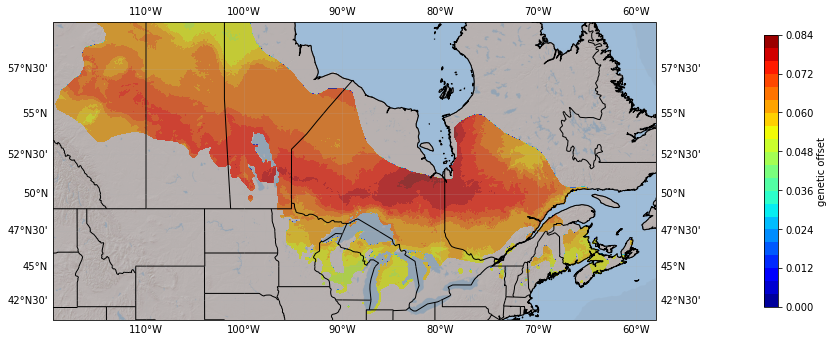

In [13]:
# create figs
for nc in ncfiles:
    # get metadata
    spp = op.basename(nc).split("-")[0]
    ensemble = op.basename(nc).split("ENSEMBLE_")[1].split("_all-envs")[0]
    ext = extent[spp]
    size = figsize[spp]

    # do the GIS
    ds, layer, vals, lons, lats = read_offset_file(nc, x_dim="latitude", y_dim="longitude")

    # fig
    ax = basemap(extent=ext, figsize=size)
    contours = plt.contourf(lons, lats, vals, 20, cmap='jet', transform=ccrs.PlateCarree(), origin='lower')
    cb = plt.colorbar(contours, pad=0.13, shrink=0.5)
    cb.set_label(f'genetic offset')

    save_pdf(op.join(figdir, f'{spp}_{ensemble}.pdf'))

    plt.show()
    
    del ax
    plt.close()

<a id='garden'></a>
# 5. look at offset to common garden

[top](#home)

In [14]:
remfiles = fs(netcdf_dir,
              pattern='wza-real-full',
              exclude=['wl', 'ENSEMBLE', 'NORM'],
              endswith='.nc')

[op.basename(f) for f in remfiles]

['combined-wza-real-full_gradient_forest_training_combined-vancouver_all-envs_WGS84_clipped_offset.nc',
 'fdc-wza-real-full_gradient_forest_training_coastal-vancouver_all-envs_WGS84_clipped_offset.nc',
 'fdi-wza-real-full_gradient_forest_training_interior-vancouver_all-envs_WGS84_clipped_offset.nc',
 'jp-wza-real-full_gradient_forest_training_jp-christine_all-envs_WGS84_clipped_offset.nc',
 'jp-wza-real-full_gradient_forest_training_jp-fontbrune_all-envs_WGS84_clipped_offset.nc']

Saved to:  /data/projects/pool_seq/phenotypic_data/offset_misc_files/projection_figs/combined_vancouver.pdf


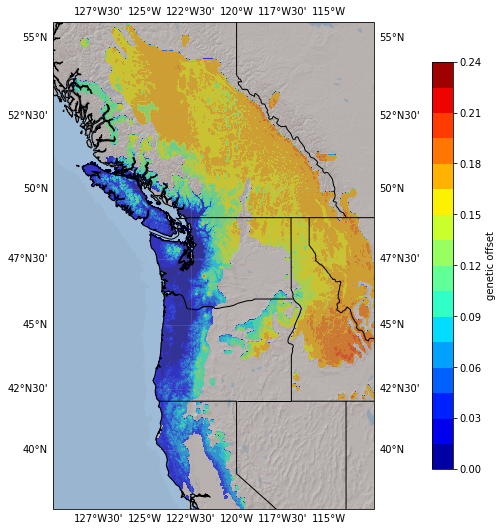

Saved to:  /data/projects/pool_seq/phenotypic_data/offset_misc_files/projection_figs/fdc_vancouver.pdf


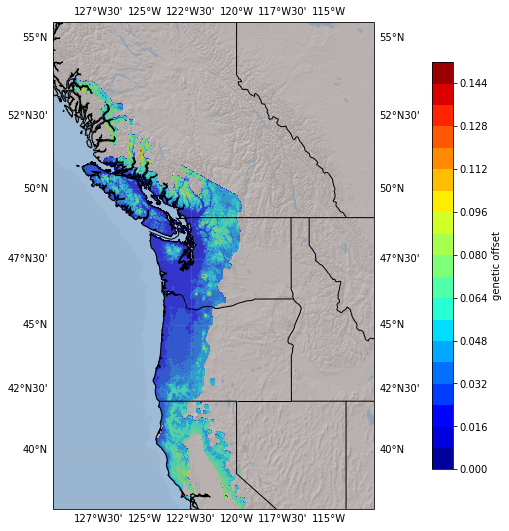

Saved to:  /data/projects/pool_seq/phenotypic_data/offset_misc_files/projection_figs/fdi_vancouver.pdf


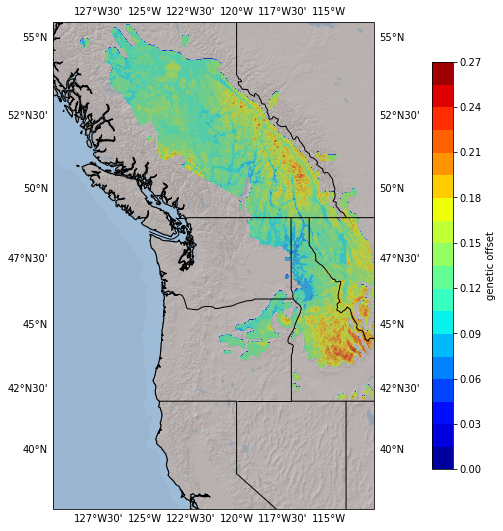

Saved to:  /data/projects/pool_seq/phenotypic_data/offset_misc_files/projection_figs/jp_christine.pdf


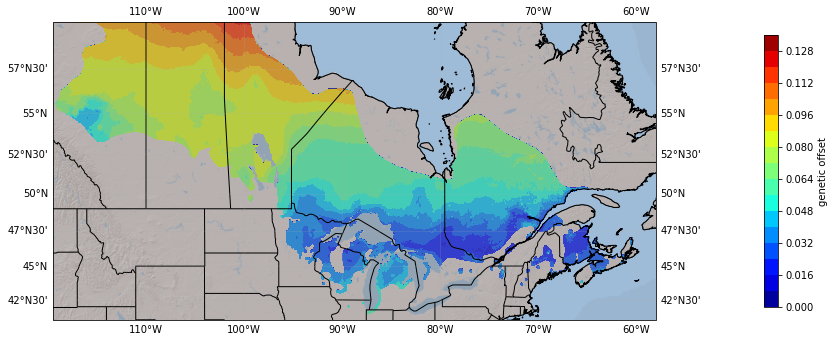

Saved to:  /data/projects/pool_seq/phenotypic_data/offset_misc_files/projection_figs/jp_fontbrune.pdf


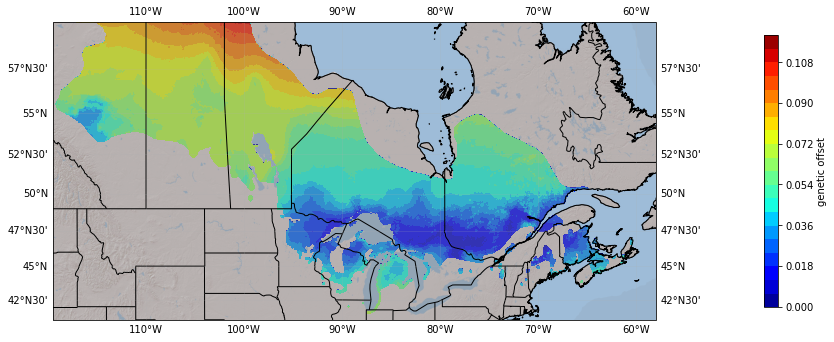

In [15]:
# create figs
for nc in remfiles:
    # get metadata
    spp = op.basename(nc).split("-")[0]
    garden = op.basename(nc).split("_all-envs")[0].split('-')[-1]
    ext = extent[spp]
    size = figsize[spp]

    # do the GIS
    ds, layer, vals, lons, lats = read_offset_file(nc, x_dim="latitude", y_dim="longitude")

    # fig
    ax = basemap(extent=ext, figsize=size)
    contours = plt.contourf(lons, lats, vals, 20, cmap='jet', transform=ccrs.PlateCarree(), origin='lower')
    cb = plt.colorbar(contours, pad=0.13, shrink=0.5)
    cb.set_label(f'genetic offset')

    save_pdf(op.join(figdir, f'{spp}_{garden}.pdf'))

    plt.show()



<a id='readme'></a>
# 6. create README

[top](#home)

In [16]:
text = '''March 29, 2022 - brandon lind
figs in this directory are of three types:
    1 - maps of offset to future climates (contain 'rcp' in file name)
    2 - maps of offset to common gardens (contain one of: 'vancouver', 'fontbrune', 'christine')
    3 - slope graphs showing rank change between offset from #1
    
all three types are using GF models using WZA loci and all populations

figs of Types 1-3 are from models trained either across both varieties ('combined'), or on a variety-specific basis ('fdi' or 'fdc')

'''

readme = op.join(figdir, 'README')
with open(readme, 'w') as o:
    o.write(text)

print(text)

March 29, 2022 - brandon lind
figs in this directory are of three types:
    1 - maps of offset to future climates (contain 'rcp' in file name)
    2 - maps of offset to common gardens (contain one of: 'vancouver', 'fontbrune', 'christine')
    3 - slope graphs showing rank change between offset from #1
    
all three types are using GF models using WZA loci and all populations

figs of Types 1-3 are from models trained either across both varieties ('combined'), or on a variety-specific basis ('fdi' or 'fdc')




In [17]:
# how long did it take to create all these figs, eh?
formatclock(dt.now() - t1, exact=True)

'0-00:24:58'